In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import seaborn as sns
from collections import Counter

In [3]:
path = Path('/data/yelp/')
assert path.exists()

In [4]:
!ls {path}

Dataset_User_Agreement.pdf	     yelp_academic_dataset_review.json
yelp_academic_dataset_business.json  yelp_academic_dataset_tip.json
yelp_academic_dataset_checkin.json   yelp_academic_dataset_user.json


In [5]:
!head {path}/yelp_academic_dataset_review.json

{"review_id":"xQY8N_XvtGbearJ5X4QryQ","user_id":"OwjRMXRC0KyPrIlcjaXeFQ","business_id":"-MhfebM0QIsKt87iDN-FNw","stars":2.0,"useful":5,"funny":0,"cool":0,"text":"As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It's what real estate agents would call \"cozy\" or \"charming\" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it's not kid friendly at all. Seriously, don't bring them.\n* the security is n

In [6]:
review_file = path/'yelp_academic_dataset_review.json'

In [7]:
%%time

sample_size = 2_000_000
simplified_reviews = path/f'yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

Processed 100000
Processed 200000
Processed 300000
Processed 400000
Processed 500000
Processed 600000
Processed 700000
Processed 800000
Processed 900000
Processed 1000000
Processed 1100000
Processed 1200000
Processed 1300000
Processed 1400000
Processed 1500000
Processed 1600000
Processed 1700000
Processed 1800000
Processed 1900000
CPU times: user 47.7 s, sys: 1.55 s, total: 49.3 s
Wall time: 49.3 s


In [8]:
!wc -l {simplified_reviews}

1999999 /data/yelp/yelp_reviews_simple_2000000.json


In [9]:
!head {simplified_reviews}

{"text": "I am actually horrified this place is still in business. My 3 year old son needed a haircut this past summer and the lure of the $7 kids cut signs got me in the door. We had to wait a few minutes as both stylists were working on people. The decor in this place is total garbage. It is so tacky. The sofa they had at the time was a pleather sofa with giant holes in it. And my son noticed ants crawling all over the floor and the furniture. It was disgusting and I should have walked out then. Actually, I should have turned around and walked out upon entering but I didn't. So the older black male stylist finishes the haircut he was doing and it's our turn. I tell him I want a #2 clipper around the back and sides and then hand cut the top into a standard boys cut. Really freaking simple, right? WRONG! Rather than use the clippers and go up to actually cut the hair, he went down. Using it moving downward doesn't cut hair, it just rubs against it. How does this man who has an alleged 

In [10]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)

In [11]:
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999999 entries, 0 to 1999998
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   stars   int64 
dtypes: int64(1), object(1)
memory usage: 30.5+ MB


In [12]:
simplified_reviews_pd

,text,stars
0,I am actually horrified this place is still in...,1
1,I love Deagan's. I do. I really do. The atmosp...,5
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
3,"Oh happy day, finally have a Canes near my cas...",4
4,This is definitely my favorite fast food sub s...,5
...,...,...
1999994,This place is excellent. I never knew about th...,5
1999995,An all-time favorite for me and my wife. We g...,5
1999996,I have been coming here for over a year now fo...,5
1999997,Worst customer service on the planet! Came in ...,1


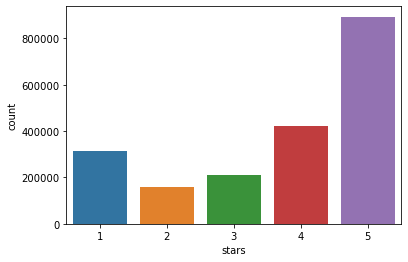

In [13]:
sns.countplot(simplified_reviews_pd['stars'])

### Create a balanced dataset
In the following cells we try to create a balanced dataset with the same amount of records in each category.

In [19]:
counter_star = Counter(simplified_reviews_pd['stars'])

In [20]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 158557)

In [21]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 153990, 5: 735443, 4: 264500, 3: 53281, 2: 0}

In [22]:
remove_amounts[1] -= 1
remove_amounts

{1: 153989, 5: 735443, 4: 264500, 3: 53281, 2: 0}

Gathering all indices that are going to be deleted.

In [23]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 4min 24s, sys: 577 ms, total: 4min 25s
Wall time: 4min 25s


1207213

In [24]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

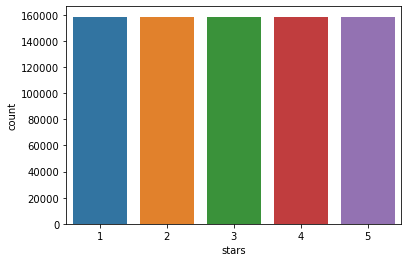

In [25]:
sns.countplot(balanced_simplified_reviews['stars'])

In [26]:
balanced_simplified_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792786 entries, 31 to 1999998
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    792786 non-null  object
 1   stars   792786 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 38.1+ MB


In [27]:
balanced_simplified_reviews.to_pickle(path/'balanced_simplified_reviews.pkl')

In [28]:
!ls {path}

Dataset_User_Agreement.pdf	     yelp_academic_dataset_review.json
balanced_simplified_reviews.pkl      yelp_academic_dataset_tip.json
yelp_academic_dataset_business.json  yelp_academic_dataset_user.json
yelp_academic_dataset_checkin.json   yelp_reviews_simple_2000000.json
